# Seção 14.08 - Regressão com Random Forests (base plano de saúde)
Para esta seção, usarei a base de dados plano_saude.csv do curso do Prof. Jones Granatyr.

In [1]:
# Instruções basiconas de sempre.

# Lidar com dataframes.
import numpy as np
import pandas as pd

# Lidar com gráficos.
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from bokeh.plotting import figure
from bokeh.io import (show,
                      output_notebook)
from plotting import (multiple_histograms_plot,
                      bar_plot_with_categorical,
                      plot_confusion_matrix,
                      plot_confusion_matrix_2,
                      plot_roc)

# Lidar com preparação de dados.
from data_prep import data_prep as dp # Eu que fiz esse modulinho ("uuuuuuuuuma bosta!").
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     StratifiedKFold)

# Lidar com validação de modelos.
from sklearn.metrics import (confusion_matrix,
                             accuracy_score,
                             classification_report)

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)

In [2]:
nomeDaBase = "../bases/plano_saude2.csv"
df = pd.read_csv(nomeDaBase, sep=",", encoding="utf-8")

In [3]:
df.head(5).T

,0,1,2,3,4
idade,18,23,28,33,38
custo,470,520,630,830,1150


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
idade    10 non-null int64
custo    10 non-null int64
dtypes: int64(2)
memory usage: 240.0 bytes


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
idade,10.0,40.5,15.138252,18.0,29.25,40.5,51.75,63.0
custo,10.0,2545.0,3021.005168,470.0,680.00,1340.0,2820.00,10100.0


### Breve análise da  base:
- não há nulos;
- só existem duas variáveis, a idade (variável independente) e o custo (variável dependente); e
- não há valores que apresentam incosistências (ex.: negativos quando não é possível).

# Comparação entre regressão linear simples e regressão com random forests

## 1. regressão linear simples

In [6]:
# Separando os fatores/previsores da resposta/target:
    
x = df.iloc[:, 0].values.reshape(-1,1)
y = df.iloc[:, 1].values.reshape(-1,1)
 
# IMPORTANTE! Tive que fazer um reshape nos valores de x e y.

In [7]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()

regressor.fit(x, y)

y_pred = regressor.predict(x)

In [8]:
print("Intercepto = {:.3f}".format(regressor.intercept_[0]))
print("Coeficiente = {:.3f}".format(regressor.coef_[0][0]))

Intercepto = -4081.782
Coeficiente = 163.624


### Visualisando:

In [9]:
reta_x = np.linspace(min(x), max(x),10).reshape(-1,1)
reta_y = regressor.predict(reta_x)
reta_df = np.concatenate((reta_x, reta_y), axis=1)
reta_df = pd.DataFrame(reta_df, columns=("idade", "custo"))

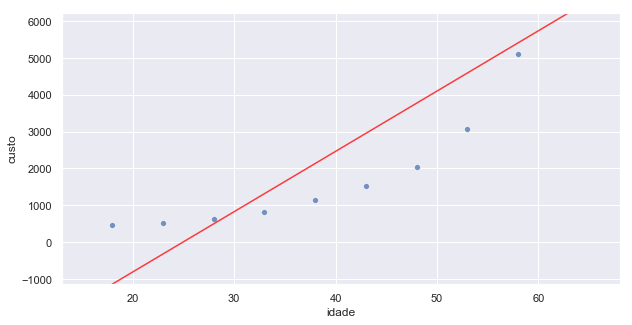

In [10]:
sns.set()
dimensoes = (10,5)
fig, ax = plt.subplots(figsize=dimensoes)
ax.set(xlim = (min(reta_x)-5, max(reta_x)+5),ylim=(min(reta_y)-5, max(reta_y)+5))
ax = sns.scatterplot(x="idade", y="custo", data=df, alpha=0.75);
ax = sns.lineplot(x="idade", y="custo", data=reta_df, alpha=.75, color="red");

### Verificando o como o modelo se saiu

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("MSE: {:.3f}".format(mean_squared_error(y, y_pred)))
print("RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y, y_pred))))
print("MAE: {:.3f}".format(mean_absolute_error(y, y_pred)))
# print("MAPE:, ", mean_absolute_percentage_error(y_test, y_pred))
print("R2: {:.3f}".format(r2_score(y, y_pred)))

################################################################################
# Cálculo do R2 ajustado:
def r2_ajustado(x, y, y_pred):
    """
    r2_ajustado retorna o R² Ajustado e recebe como argumento as séries com o
    valor alvo teste e o predito.
    """
    n = x.shape[0]
    k = x.shape[1]
    return (1-((n-1)/(n-(k+1)))*(1-r2_score(y, y_pred)))
################################################################################

print("R2 Ajustado: {:.3}".format(r2_ajustado(x, y, y_pred)))

MSE: 2691915.879
RMSE: 1640.706
MAE: 1289.745
R2: 0.672
R2 Ajustado: 0.631


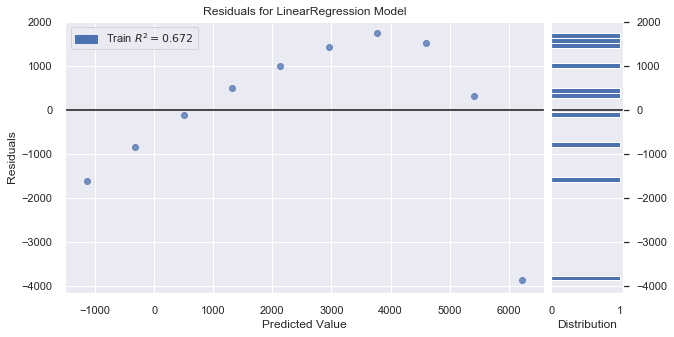

In [12]:
from yellowbrick.regressor import ResidualsPlot

sns.set()
dimensoes = (10,5)
fig, ax = plt.subplots(figsize=dimensoes)

visualizador = ResidualsPlot(regressor)
visualizador.fit(x, y)
visualizador.poof();

## 2. Regressão com random forests

In [13]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
regressorTree = RandomForestRegressor(n_estimators=10, criterion="mae")
regressorTree.fit(x, y)

y_tree_pred = regressorTree.predict(x)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



### Visualisando:

In [20]:
reta_x = np.linspace(min(x)-0.5, max(x)+0.5,450).reshape(-1,1)
reta_y = regressorTree.predict(reta_x).reshape(-1,1)
reta_df = np.concatenate((reta_x, reta_y), axis=1)
reta_df = pd.DataFrame(reta_df, columns=("idade", "custo"))

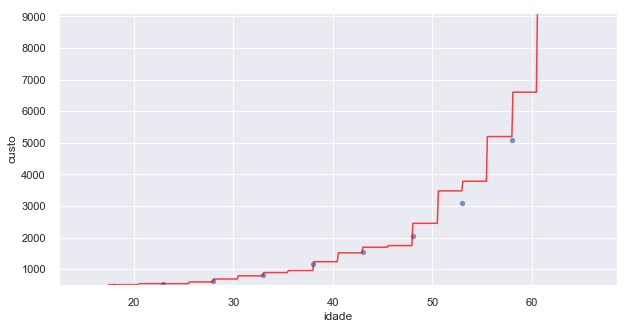

In [21]:
sns.set()
dimensoes = (10,5)
fig, ax = plt.subplots(figsize=dimensoes)
ax.set(xlim = (min(reta_x)-5, max(reta_x)+5),ylim=(min(reta_y)-5, max(reta_y)+5))
ax = sns.scatterplot(x="idade", y="custo", data=df, alpha=0.75);
ax = sns.lineplot(x="idade", y="custo", data=reta_df, alpha=.75, color="red");

### Verificando o como o modelo se saiu

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("MSE: {:.3f}".format(mean_squared_error(y, y_tree_pred)))
print("RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y, y_tree_pred))))
print("MAE: {:.3f}".format(mean_absolute_error(y, y_tree_pred)))
# print("MAPE:, ", mean_absolute_percentage_error(y_test, y_pred))
print("R2: {:.3f}".format(r2_score(y, y_tree_pred)))

################################################################################
# Cálculo do R2 ajustado:
def r2_ajustado(x, y, y_pred):
    """
    r2_ajustado retorna o R² Ajustado e recebe como argumento as séries com o
    valor alvo teste e o predito.
    """
    n = x.shape[0]
    k = x.shape[1]
    return (1-((n-1)/(n-(k+1)))*(1-r2_score(y, y_pred)))
################################################################################

print("R2 Ajustado: {:.3}".format(r2_ajustado(x, y, y_tree_pred)))